In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils import resample
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import joblib
from datetime import datetime

In [2]:
class Config:
    DATA_PATH = r"H:\Nasa Space Apps 2025\data\cleaned_data.csv"
    BATCH_SIZE = 32
    NUM_EPOCHS = 500
    LEARNING_RATE = 0.001
    WEIGHT_DECAY = 0.01
    PATIENCE = 50
    TEST_SIZE = 0.15
    VAL_SIZE = 0.15
    USE_CLASS_WEIGHTS = True
    DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

config = Config()

In [3]:
df = pd.read_csv(config.DATA_PATH)
df.head()

,kepid,kepoi_name,koi_disposition,koi_score,koi_period,koi_duration,koi_depth,koi_time0bk,koi_prad,koi_ror,...,koi_period_err1,koi_period_err2,koi_duration_err1,koi_duration_err2,koi_depth_err1,koi_depth_err2,koi_prad_err1,koi_prad_err2,koi_steff_err1,koi_steff_err2
0,10797460,K00752.01,CONFIRMED,1.000,9.488036,2.95750,615.8,170.538750,2.26,0.022344,...,2.775000e-05,-2.775000e-05,0.08190,-0.08190,19.5,-19.5,0.26,-0.15,81.0,-81.0
1,10797460,K00752.02,CONFIRMED,0.969,54.418383,4.50700,874.8,162.513840,2.83,0.027954,...,2.479000e-04,-2.479000e-04,0.11600,-0.11600,35.5,-35.5,0.32,-0.19,81.0,-81.0
2,10811496,K00753.01,CANDIDATE,0.000,19.899140,1.78220,10829.0,175.850252,14.60,0.154046,...,1.494000e-05,-1.494000e-05,0.03410,-0.03410,171.0,-171.0,3.92,-1.31,158.0,-176.0
3,10848459,K00754.01,FALSE POSITIVE,0.000,1.736952,2.40641,8079.2,170.307565,33.46,0.387394,...,2.630000e-07,-2.630000e-07,0.00537,-0.00537,12.8,-12.8,8.50,-2.83,157.0,-174.0
4,10854555,K00755.01,CONFIRMED,1.000,2.525592,1.65450,603.3,171.595550,2.75,0.024064,...,3.761000e-06,-3.761000e-06,0.04200,-0.04200,16.9,-16.9,0.88,-0.35,169.0,-211.0


In [4]:
df = df.drop(columns=['kepoi_name', 'kepid'], errors='ignore')

X = df.drop(columns=['koi_disposition', 'koi_vet_stat', 'koi_vet_date', 'koi_disp_prov'], errors='ignore')
y = df['koi_disposition']

In [32]:
X.columns

Index(['koi_score', 'koi_period', 'koi_duration', 'koi_depth', 'koi_time0bk',
       'koi_prad', 'koi_ror', 'koi_dor', 'koi_impact', 'koi_incl', 'koi_srad',
       'koi_smass', 'koi_steff', 'koi_slogg', 'koi_smet', 'koi_kepmag',
       'koi_fpflag_nt', 'koi_fpflag_ss', 'koi_fpflag_co', 'koi_fpflag_ec',
       'koi_period_err1', 'koi_period_err2', 'koi_duration_err1',
       'koi_duration_err2', 'koi_depth_err1', 'koi_depth_err2',
       'koi_prad_err1', 'koi_prad_err2', 'koi_steff_err1', 'koi_steff_err2'],
      dtype='object')

In [5]:
missing_values = X.isnull().sum()
if missing_values.sum() > 0:
    print("\nWarning: Missing values detected:")
    print(missing_values[missing_values > 0])
    print("Filling missing values with median...")
    X = X.fillna(X.median())


koi_kepmag    1
dtype: int64
Filling missing values with median...


In [6]:
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
print(f"\nLabel encoding: {dict(zip(label_encoder.classes_, range(len(label_encoder.classes_))))}")


Label encoding: {'CANDIDATE': 0, 'CONFIRMED': 1, 'FALSE POSITIVE': 2}


In [7]:
if config.USE_CLASS_WEIGHTS:
    X_balanced = X
    y_balanced = y_encoded
    
    class_weights = compute_class_weight('balanced', classes=np.unique(y_balanced), y=y_balanced)
    print(f"\nComputed class weights: {class_weights}")
else:
    df_combined = pd.concat([X, pd.Series(y_encoded, name='target')], axis=1)
    
    classes = np.unique(y_encoded)
    class_dfs = [df_combined[df_combined.target == c] for c in classes]
    
    min_samples = min(len(df) for df in class_dfs)
    print(f"\nOriginal class sizes: {[len(df) for df in class_dfs]}")
    
    downsampled_dfs = [
        resample(df, replace=False, n_samples=min_samples, random_state=42)
        for df in class_dfs
    ]
    
    df_balanced = pd.concat(downsampled_dfs)
    X_balanced = df_balanced.drop(columns=['target'])
    y_balanced = df_balanced['target'].values
    
    print(f"\nBalanced class distribution: {np.bincount(y_balanced)}")


Computed class weights: [1.6109146 1.1609614 0.6588138]


In [8]:
X_temp, X_test, y_temp, y_test = train_test_split(
    X_balanced, y_balanced, 
    test_size=config.TEST_SIZE, 
    random_state=42,
    stratify=y_balanced
)

val_size_adjusted = config.VAL_SIZE / (1 - config.TEST_SIZE)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=val_size_adjusted,
    random_state=42,
    stratify=y_temp
)

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

In [10]:
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.int64)
y_val_tensor = torch.tensor(y_val, dtype=torch.int64)
y_test_tensor = torch.tensor(y_test, dtype=torch.int64)

# DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=config.BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=config.BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=config.BATCH_SIZE, shuffle=False)

In [11]:
class ImprovedClassifier(nn.Module):
    def __init__(self, input_size, num_classes, dropout_rate=0.3):
        super(ImprovedClassifier, self).__init__()
        
        self.layer_1 = nn.Linear(input_size, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(dropout_rate)
        
        self.layer_2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(dropout_rate)
        
        self.layer_3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(dropout_rate * 0.67)
        
        self.layer_4 = nn.Linear(64, num_classes)
        
        self.relu = nn.ReLU()
        
        # Initialize weights
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm1d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.dropout1(x)
        
        x = self.layer_2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.dropout2(x)
        
        x = self.layer_3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.dropout3(x)
        
        x = self.layer_4(x)
        return x

In [12]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    correct = 0
    total = 0
    
    for batch_X, batch_y in loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == batch_y).sum().item()
        total += batch_y.size(0)
    
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

def validate(model, loader, criterion, device):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for batch_X, batch_y in loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)
            
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            total_loss += loss.item() * batch_X.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == batch_y).sum().item()
            total += batch_y.size(0)
    
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

In [13]:
input_size = X_train_scaled.shape[1]
num_classes = len(np.unique(y_balanced))

model = ImprovedClassifier(input_size, num_classes).to(config.DEVICE)

if config.USE_CLASS_WEIGHTS:
    class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(config.DEVICE)
    criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)
else:
    criterion = nn.CrossEntropyLoss()

optimizer = optim.AdamW(model.parameters(), lr=config.LEARNING_RATE, weight_decay=config.WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=10, verbose=True)

c:\Users\CRIZMA\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


In [14]:
best_val_loss = float('inf')
best_val_acc = 0
patience_counter = 0

train_losses = []
train_accs = []
val_losses = []
val_accs = []

start_time = datetime.now()

for epoch in range(config.NUM_EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, config.DEVICE)
    val_loss, val_acc = validate(model, val_loader, criterion, config.DEVICE)
    
    scheduler.step(val_loss)
    
    train_losses.append(train_loss)
    train_accs.append(train_acc)
    val_losses.append(val_loss)
    val_accs.append(val_acc)
    
    # Save best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_val_acc = val_acc
        patience_counter = 0
        
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc,
        }, 'best_model.pth')
    else:
        patience_counter += 1
    
    if epoch % 25 == 0:
        print(f'Epoch [{epoch+1}/{config.NUM_EPOCHS}]')
        print(f'  Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
        print(f'  Val Loss:   {val_loss:.4f} | Val Acc:   {val_acc:.4f}')
        print(f'  LR: {optimizer.param_groups[0]["lr"]:.6f} | Patience: {patience_counter}/{config.PATIENCE}')
    
    if patience_counter >= config.PATIENCE:
        print(f'\nEarly stopping at epoch {epoch+1}')
        break

Epoch [1/500]
  Train Loss: 1.1831 | Train Acc: 0.7090
  Val Loss:   0.6188 | Val Acc:   0.7415
  LR: 0.001000 | Patience: 0/50
Epoch [26/500]
  Train Loss: 0.3109 | Train Acc: 0.9017
  Val Loss:   0.2794 | Val Acc:   0.9143
  LR: 0.001000 | Patience: 1/50
Epoch [51/500]
  Train Loss: 0.2738 | Train Acc: 0.9126
  Val Loss:   0.2942 | Val Acc:   0.9066
  LR: 0.000250 | Patience: 26/50
Epoch [76/500]
  Train Loss: 0.2694 | Train Acc: 0.9125
  Val Loss:   0.3795 | Val Acc:   0.8509
  LR: 0.000125 | Patience: 20/50
Epoch [101/500]
  Train Loss: 0.2628 | Train Acc: 0.9160
  Val Loss:   0.3992 | Val Acc:   0.8530
  LR: 0.000016 | Patience: 45/50

Early stopping at epoch 106


In [15]:
training_time = datetime.now() - start_time
print(f"\nTraining completed in {training_time}")
print(f"Best validation loss: {best_val_loss:.4f}")
print(f"Best validation accuracy: {best_val_acc:.4f}")

checkpoint = torch.load('best_model.pth')
model.load_state_dict(checkpoint['model_state_dict'])
print(f"\nLoaded best model from epoch {checkpoint['epoch']+1}")


Training completed in 0:01:30.581145
Best validation loss: 0.2744
Best validation accuracy: 0.9157


C:\Users\CRIZMA\AppData\Local\Temp\ipykernel_32400\3486443350.py:7: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('best_model.pth')



Loaded best model from epoch 56


RuntimeError: matplotlib does not support generators as input

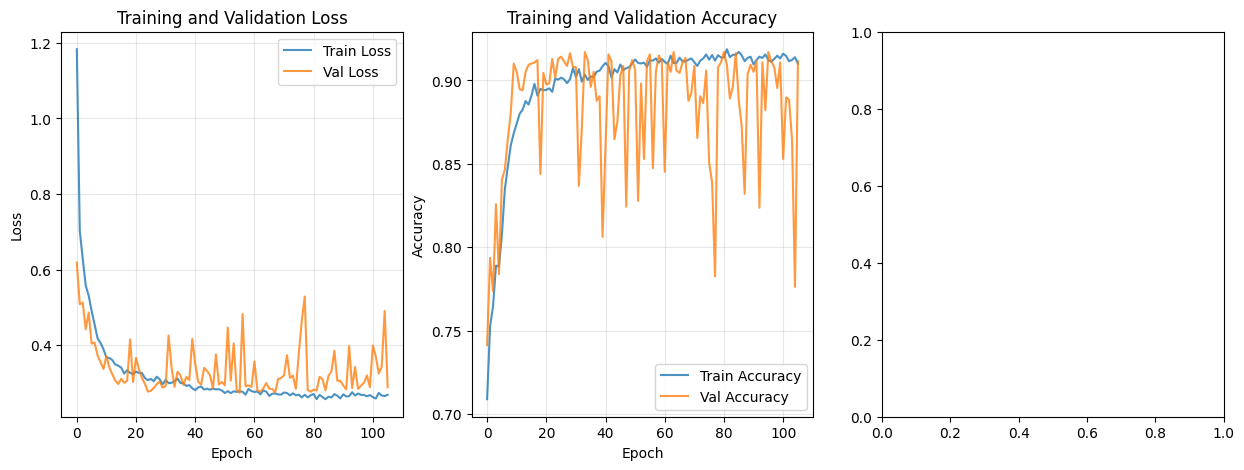

In [16]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss', alpha=0.8)
plt.plot(val_losses, label='Val Loss', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 2)
plt.plot(train_accs, label='Train Accuracy', alpha=0.8)
plt.plot(val_accs, label='Val Accuracy', alpha=0.8)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 3, 3)
plt.plot(optimizer.param_groups[0]['lr'] for _ in range(len(train_losses)))
lrs = [optimizer.param_groups[0]['lr']]
for i in range(1, len(train_losses)):
    if i % 10 == 0 and val_losses[i] >= val_losses[i-1]:
        lrs.append(lrs[-1] * 0.5)
    else:
        lrs.append(lrs[-1])
plt.plot(lrs[:len(train_losses)])
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')
plt.yscale('log')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_history.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
test_loss, test_acc = validate(model, test_loader, criterion, config.DEVICE)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")

# Get predictions for detailed metrics
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(config.DEVICE)
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(batch_y.numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)


Test Loss: 0.2427
Test Accuracy: 0.9275


In [19]:
print(classification_report(all_labels, all_preds, target_names=label_encoder.classes_, digits=4))

                precision    recall  f1-score   support

     CANDIDATE     0.8025    0.8754    0.8374       297
     CONFIRMED     0.9091    0.8738    0.8911       412
FALSE POSITIVE     0.9944    0.9793    0.9868       726

      accuracy                         0.9275      1435
     macro avg     0.9020    0.9095    0.9051      1435
  weighted avg     0.9302    0.9275    0.9284      1435



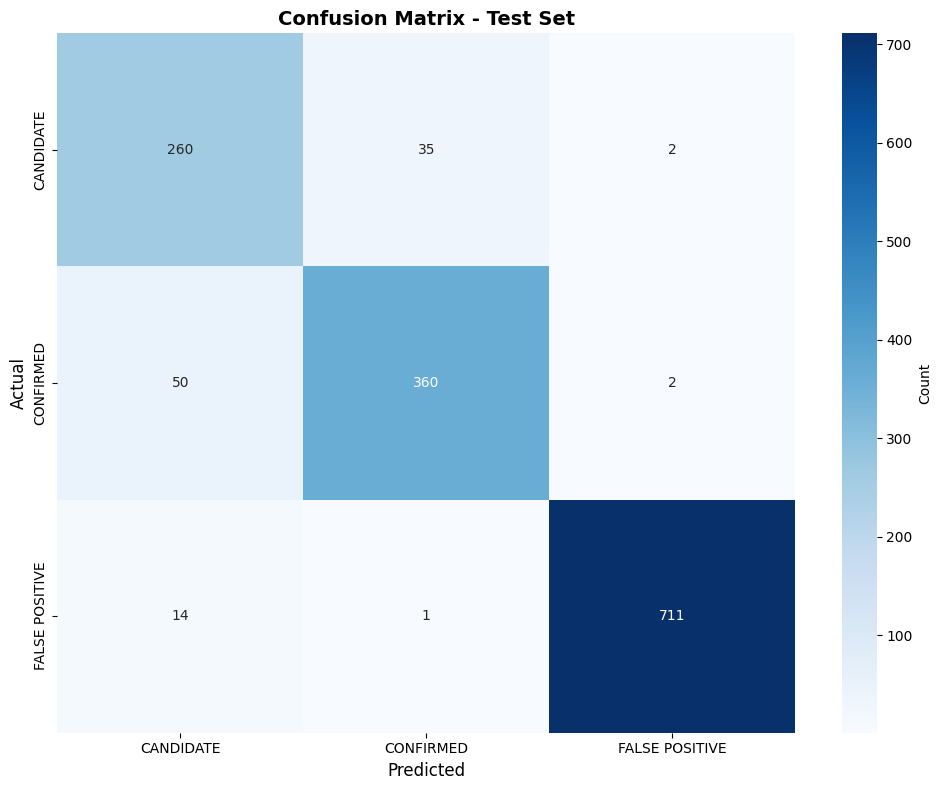

In [20]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_,
            cbar_kws={'label': 'Count'})
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

In [21]:
def get_feature_importance(model, X_tensor, y_tensor, device):
    model.eval()
    X_tensor = X_tensor.to(device)
    X_tensor.requires_grad = True
    
    outputs = model(X_tensor)
    loss = nn.CrossEntropyLoss()(outputs, y_tensor.to(device))
    loss.backward()
    
    importance = X_tensor.grad.abs().mean(dim=0)
    return importance.cpu().detach().numpy()

feature_importance = get_feature_importance(model, X_train_tensor, y_train_tensor, config.DEVICE)

feature_importance_df = pd.DataFrame({
    'feature': list(X_balanced.columns),
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print(feature_importance_df.head(15).to_string(index=False))

          feature  importance
    koi_fpflag_nt    0.000154
koi_duration_err1    0.000071
          koi_dor    0.000067
koi_duration_err2    0.000062
     koi_duration    0.000059
       koi_period    0.000058
   koi_depth_err1    0.000029
   koi_depth_err2    0.000022
        koi_depth    0.000022
        koi_score    0.000016
          koi_ror    0.000016
  koi_period_err1    0.000014
    koi_fpflag_co    0.000011
    koi_fpflag_ec    0.000010
  koi_period_err2    0.000009


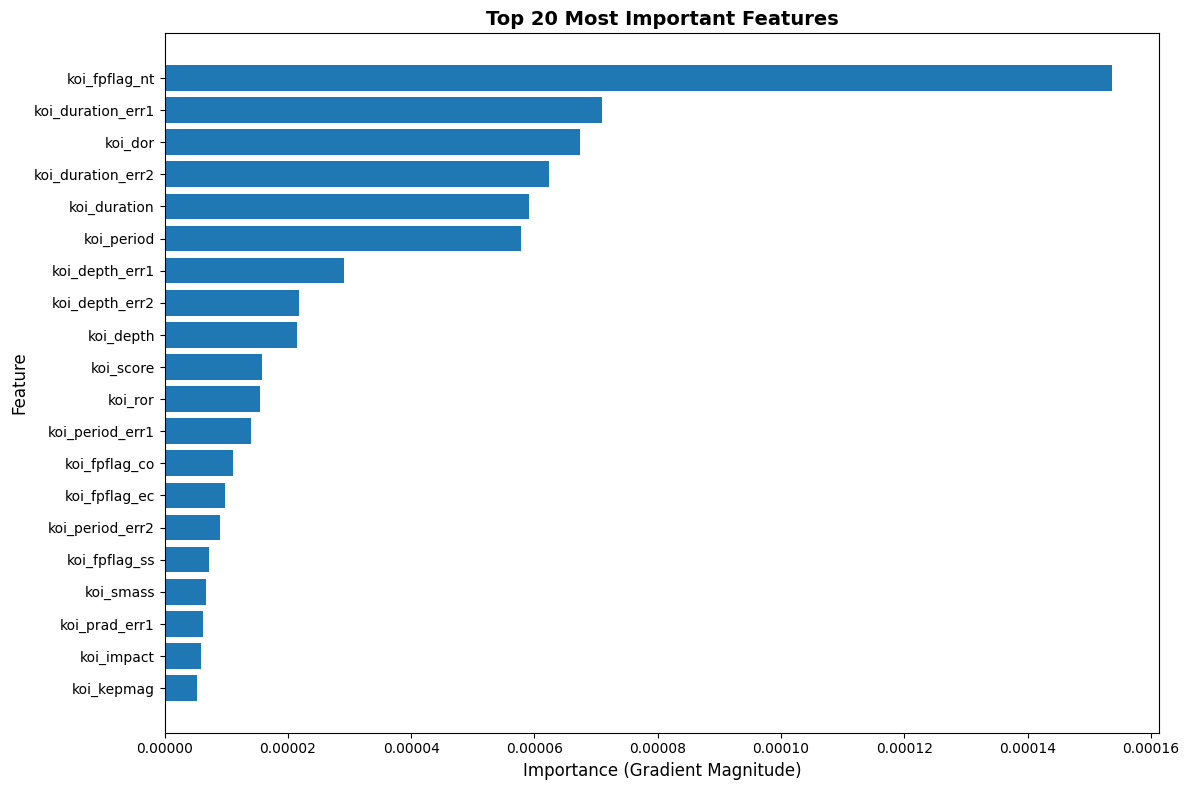

In [22]:
plt.figure(figsize=(12, 8))
top_n = 20
top_features = feature_importance_df.head(top_n)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance (Gradient Magnitude)', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title(f'Top {top_n} Most Important Features', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()

In [23]:
joblib.dump(scaler, 'exoplanet_scaler.pkl')
joblib.dump(label_encoder, 'exoplanet_label_encoder.pkl')

# Save model info
model_info = {
    'input_size': input_size,
    'num_classes': num_classes,
    'feature_names': list(X_balanced.columns),
    'label_mapping': dict(zip(label_encoder.classes_, range(len(label_encoder.classes_)))),
    'training_time': str(training_time),
    'best_val_loss': best_val_loss,
    'best_val_acc': best_val_acc,
    'test_loss': test_loss,
    'test_acc': test_acc,
    'feature_importance': feature_importance_df.to_dict(),
    'config': {
        'batch_size': config.BATCH_SIZE,
        'learning_rate': config.LEARNING_RATE,
        'weight_decay': config.WEIGHT_DECAY,
        'use_class_weights': config.USE_CLASS_WEIGHTS,
    }
}

with open('model_info.pkl', 'wb') as f:
    pickle.dump(model_info, f)

print("\nSaved files:")
print("  - best_model.pth (model weights)")
print("  - exoplanet_scaler.pkl (feature scaler)")
print("  - exoplanet_label_encoder.pkl (label encoder)")
print("  - model_info.pkl (model metadata)")
print("  - training_history.png")
print("  - confusion_matrix.png")
print("  - feature_importance.png")


Saved files:
  - best_model.pth (model weights)
  - exoplanet_scaler.pkl (feature scaler)
  - exoplanet_label_encoder.pkl (label encoder)
  - model_info.pkl (model metadata)
  - training_history.png
  - confusion_matrix.png
  - feature_importance.png


In [ ]:
def load_and_predict(features, return_probabilities=False):
    import torch
    import torch.nn as nn
    import joblib
    import pickle
    import numpy as np
    
    scaler = joblib.load('exoplanet_scaler.pkl')
    label_encoder = joblib.load('exoplanet_label_encoder.pkl')
    
    with open('model_info.pkl', 'rb') as f:
        model_info = pickle.load(f)
    
    features = np.array(features).reshape(1, -1)
    if features.shape[1] != model_info['input_size']:
        raise ValueError(f"Expected {model_info['input_size']} features, got {features.shape[1]}")
    
    class ImprovedClassifier(nn.Module):
        def __init__(self, input_size, num_classes, dropout_rate=0.3):
            super(ImprovedClassifier, self).__init__()
            self.layer_1 = nn.Linear(input_size, 256)
            self.bn1 = nn.BatchNorm1d(256)
            self.dropout1 = nn.Dropout(dropout_rate)
            self.layer_2 = nn.Linear(256, 128)
            self.bn2 = nn.BatchNorm1d(128)
            self.dropout2 = nn.Dropout(dropout_rate)
            self.layer_3 = nn.Linear(128, 64)
            self.bn3 = nn.BatchNorm1d(64)
            self.dropout3 = nn.Dropout(dropout_rate * 0.67)
            self.layer_4 = nn.Linear(64, num_classes)
            self.relu = nn.ReLU()

        def forward(self, x):
            x = self.relu(self.bn1(self.layer_1(x)))
            x = self.dropout1(x)
            x = self.relu(self.bn2(self.layer_2(x)))
            x = self.dropout2(x)
            x = self.relu(self.bn3(self.layer_3(x)))
            x = self.dropout3(x)
            x = self.layer_4(x)
            return x
    
    model = ImprovedClassifier(model_info['input_size'], model_info['num_classes'])
    checkpoint = torch.load('best_model.pth', map_location='cpu', weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    
    features_scaled = scaler.transform(features)
    features_tensor = torch.tensor(features_scaled, dtype=torch.float32)
    
    with torch.no_grad():
        outputs = model(features_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        _, predicted = torch.max(outputs, 1)
    
    prediction = predicted.item()
    confidence = probabilities[0][prediction].item()
    label = label_encoder.inverse_transform([prediction])[0]
    
    if return_probabilities:
        prob_dict = {
            label_encoder.inverse_transform([i])[0]: probabilities[0][i].item()
            for i in range(len(label_encoder.classes_))
        }
        return prediction, confidence, label, prob_dict
    
    return prediction, confidence, label

In [31]:
test_idx = np.random.randint(0, len(X_test))
test_sample = X_test.iloc[test_idx].values
actual_label = label_encoder.inverse_transform([y_test[test_idx]])[0]

print(f"\nTest sample index: {test_idx}")
print(f"Actual label: {actual_label}")

prediction, confidence, predicted_label, probabilities = load_and_predict(test_sample, return_probabilities=True)

print(f"\nPrediction: {predicted_label}")
print(f"Confidence: {confidence:.4f}")
print(f"Correct: {predicted_label == actual_label}")

print("\nClass probabilities:")
for class_name, prob in sorted(probabilities.items(), key=lambda x: x[1], reverse=True):
    print(f"  {class_name}: {prob:.4f}")

print(f"\nFinal Results:")
print(f"  Best Validation Accuracy: {best_val_acc:.4f}")
print(f"  Test Accuracy: {test_acc:.4f}")
print(f"  Training Time: {training_time}")


Test sample index: 146
Actual label: CANDIDATE

Prediction: CANDIDATE
Confidence: 0.9595
Correct: True

Class probabilities:
  CANDIDATE: 0.9595
  CONFIRMED: 0.0328
  FALSE POSITIVE: 0.0077

Final Results:
  Best Validation Accuracy: 0.9157
  Test Accuracy: 0.9275
  Training Time: 0:01:30.581145


C:\Users\CRIZMA\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
